In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import os
from importlib import reload

In [2]:
import dataset_utils
from glob import glob

In [3]:
reload(dataset_utils)

<module 'dataset_utils' from '/Users/katiezhou/P4P-mmWave/MMWave_Radar_Human_Tracking_and_Fall_detection/dataset_utils.py'>

In [4]:
INIT_TIMESTAMP = "12_10_2024_pointnet_padded_bg_rm_augmented"

In [5]:
bg_noise_dir = './data/03_09_2024_katie_pc_bg_noise/unique_bg_points.pkl'
with open(bg_noise_dir, 'rb') as file:
        background_data = pickle.load(file)

In [6]:
def background_subtraction(background_data, current_frame_data, threshold=0.1):
    filtered_data = []
    points_removed = []
    num_points_removed = 0
    for point in current_frame_data:
        # print(point)
        distances = np.linalg.norm(background_data[:, :3]- point[:3], axis =1)
        # filtered_data.append(point)
        if np.min(distances) > threshold:
            filtered_data.append(point)
        else:
            filtered_data.append([0,0,0,0,0])
            points_removed.append(point)
    return filtered_data

In [7]:
def no_background_subtraction(current_frame_data):
    filtered_data = []
    for point in current_frame_data:
        filtered_data.append(point)
    return filtered_data

In [8]:
def parse_dataset(num_points, DATA_DIR):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    # bg_rm_arr = no_background_subtraction(arr)
                    bg_rm_arr = background_subtraction(background_data, arr)
                    train_points_sample.append(bg_rm_arr)
                train_points_sample = np.array(train_points_sample).reshape(-1,5).astype(np.float16)
                train_points.append(train_points_sample)
                train_labels.append(i)
               
        
        for f in test_files:
            test_points_sample = []
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    # bg_rm_arr = no_background_subtraction(arr)
                    bg_rm_arr = background_subtraction(background_data, arr)
                    test_points_sample.append(bg_rm_arr)
                test_points_sample = np.array(test_points_sample).reshape(-1,5).astype(np.float16)
                test_points.append(test_points_sample)
                test_labels.append(i)
    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [9]:
DATA_DIR = "cluster_data/padded"
NUM_POINTS = 300
NUM_FRAMES = 3
NUM_CLASSES = 4
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: picking_up
processing class: jumping
processing class: sitting
train_points shape: (1393, 300, 5)
test_points shape: (349, 300, 5)
train_labels shape: (1393,)
test_labels shape: (349,)


In [10]:
print(CLASS_MAP)

{0: 'walking', 1: 'picking_up', 2: 'jumping', 3: 'sitting'}


In [11]:
from tensorflow import data as tf_data
import keras
import PointNET



In [33]:
keras.utils.set_random_seed(seed=42)
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(buffer_size=len(train_points))
test_dataset = test_dataset.shuffle(buffer_size=len(test_points)).batch(None)

train_dataset = dataset.take(train_dataset_size).map(PointNET.augment)
train_dataset = train_dataset.batch(BATCH_SIZE)
# train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

ValueError: Attempt to convert a value (None) with an unsupported type (<class 'NoneType'>) to a Tensor.

In [13]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [14]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_features, NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (300, 5)  # Adjust this based on your input data
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)



In [15]:

model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)
model.summary()

Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 300, 32)   │        192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 300, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 300, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 300, 64)   │      2,112 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 300, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 300, 512)  │     33,280 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 512)  │      2,048 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 300, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_2[0][… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 25)        │      3,225 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 5)      │          0 │ dense_2[0][0]   

 Total params: 3,112,925 (11.87 MB)

 Trainable params: 3,108,381 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [17]:

checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [19]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'best.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    save_best_only = True,
    verbose=1  # Print a message when saving
)

In [20]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks= [ checkpoint_callback, early_stopping_callback]  
)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 6.6228 - sparse_categorical_accuracy: 0.4650
Epoch 1: val_loss improved from inf to 6.04965, saving model to model/checkpoints/12_10_2024_pointnet_padded_bg_rm_augmented/best.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 199ms/step - loss: 6.5964 - sparse_categorical_accuracy: 0.4666 - val_loss: 6.0496 - val_sparse_categorical_accuracy: 0.4480
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 4.8526 - sparse_categorical_accuracy: 0.7358
Epoch 2: val_loss improved from 6.04965 to 4.67453, saving model to model/checkpoints/12_10_2024_pointnet_padded_bg_rm_augmented/best.weights.h5
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - loss: 4.8519 - sparse_categorical_accuracy: 0.7355 - val_loss: 4.6745 - val_sparse_categorical_accuracy: 0.7527
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 4.7675 - sparse_categorical_accuracy: 0.7829
Epoch 3: val_loss improved from 4.67453 to 4.62052, saving model to model/checkpoints

In [34]:
#reload model
model = create_pointnet_model(input_shape, num_features, NUM_CLASSES=4)

checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
filepath=os.path.join(checkpoint_dir, 'best.weights.h5')
model.load_weights(filepath)

In [35]:
from matplotlib import pyplot as plt


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
[[[ 3.7575e-03  5.0735e-04 -2.1095e-03  1.5335e-03 -2.9507e-03]
  [-1.9054e-03  4.8180e-03  2.6855e-03 -1.0567e-03 -3.9062e-03]
  [ 8.3160e-04 -2.5196e-03  1.2207e-03  2.8114e-03  4.7951e-03]
  ...
  [ 3.8414e-03 -1.2302e-03  3.6888e-03 -1.9722e-03  8.8882e-04]
  [ 3.3531e-03 -2.5978e-03  1.3199e-03 -2.8419e-03  3.4447e-03]
  [-4.1199e-04  3.3760e-03 -3.5648e-03 -9.8801e-04 -3.0289e-03]]

 [[ 5.8887e-01  3.2285e+00  1.6113e+00  2.5537e-01  4.4000e+02]
  [ 4.4518e-03 -1.1921e-03 -3.0861e-03 -2.4223e-03 -1.6117e-03]
  [ 5.8252e-01  3.1992e+00  1.5684e+00  6.2402e-01  3.8800e+02]
  ...
  [-1.8692e-04 -5.2643e-04  4.0169e-03 -2.6760e-03  3.1242e-03]
  [ 1.9646e-03 -2.3937e-03  2.6779e-03 -1.1730e-03  4.7264e-03]
  [ 6.3672e-01  3.2031e+00  1.6934e+00 -3.7964e-01  3.3800e+02]]

 [[ 3.5362e-03 -1.4954e-03  4.1008e-03  6.7520e-04 -1.8177e-03]
  [-2.7542e-03  2.4336e+00  3.2397e-01  2.4646e-01  2.9100e+02]
  [-1.0567e-03  2.7351e-03  3.1548e-03 -2.5787e-0

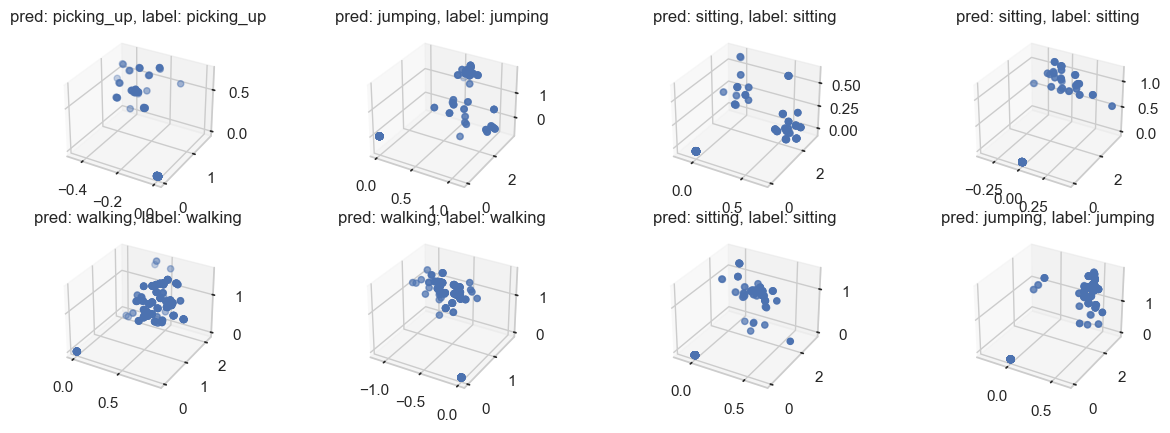

In [36]:
data = train_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
preds = preds.numpy()
labels = labels.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
num_points_to_plot = min(len(points), 8)

for i in range(num_points_to_plot):  # Update to use num_points_to_plot
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    
    # Set title with prediction and label
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels[i]]
        )
    )

    
    ax.set_axis_on()
plt.show()

In [37]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    print("pred is", preds)
    print(batch.shape)
    preds = np.argmax(preds, axis=-1)
    print("argmax is", preds)
    predictions.extend(preds)

predictions = np.array(predictions)
accuracy = np.sum(predictions == test_labels) / len(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
pred is [[9.9821383e-01 1.1612320e-03 1.6430115e-04 4.6050511e-04]
 [9.9734449e-01 1.6146760e-03 1.9163910e-04 8.4909517e-04]
 [9.9711490e-01 2.1832674e-03 1.9667910e-04 5.0512218e-04]
 ...
 [1.8289305e-04 1.9954073e-03 9.5417455e-04 9.9686766e-01]
 [1.5146176e-04 1.6712410e-03 7.4503938e-04 9.9743223e-01]
 [2.4347917e-04 3.6227105e-03 1.1278894e-03 9.9500591e-01]]
(349, 300, 5)
argmax is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 1 2 2
 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [43]:
BATCH_SIZE = 1
seed = 42
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
test_dataset = test_dataset.shuffle(len(test_points),).batch(BATCH_SIZE)


In [44]:
predictions = []
true_labels = []

# Iterate over the test_dataset to make predictions
for batch, labels in test_dataset:
    for sample, label in zip(batch, labels):
        sample = np.expand_dims(sample, axis=0)  # Add batch dimension
        preds = model.predict(sample)  # Make a prediction
        preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
        
        predictions.extend(preds)  # Extend the predictions list
        true_labels.extend([label.numpy()])  # Append the true label (not extend)

# Convert to numpy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)
predictions = np.array(predictions)
accuracy = np.sum(predictions == true_labels) / len(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

2024-10-12 23:21:36.513553: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score     support
0              0.958678  0.966667  0.962656  120.000000
1              0.882353  0.937500  0.909091   80.000000
2              0.960526  0.912500  0.935897   80.000000
3              0.955224  0.927536  0.941176   69.000000
accuracy       0.939828  0.939828  0.939828    0.939828
macro avg      0.939195  0.936051  0.937205  349.000000
weighted avg   0.940923  0.939828  0.939997  349.000000


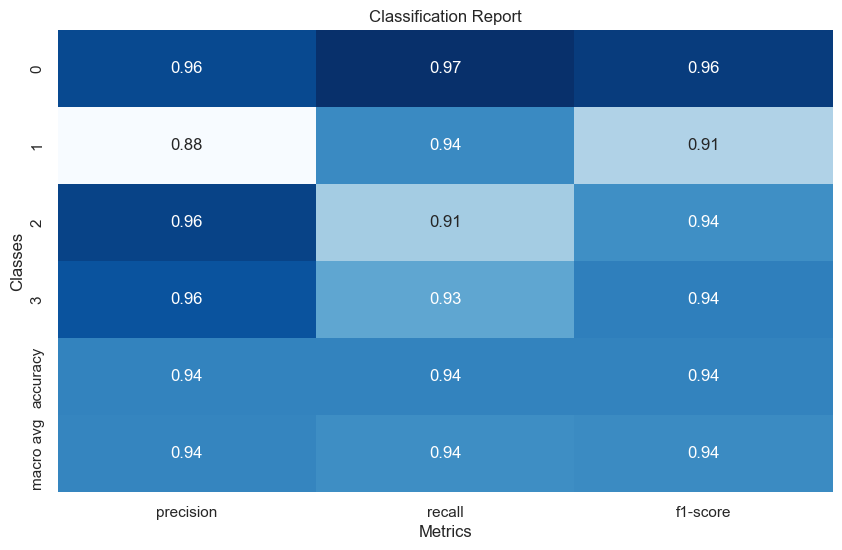

In [47]:
import pandas as pd
from sklearn.metrics import classification_report

# Assume `true_labels` contains the true class labels for your test set
# And `predictions` contains the predicted class labels

# Generate the classification report
report = classification_report(true_labels, predictions, output_dict=True)

# Convert the report to a DataFrame for better formatting
report_df = pd.DataFrame(report).transpose()

# Print the DataFrame
print(report_df)

# If you want to format the DataFrame nicely in Jupyter Notebook
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a heatmap to visualize the report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, fmt=".2f", cmap='Blues', cbar=False)
plt.title("Classification Report")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()


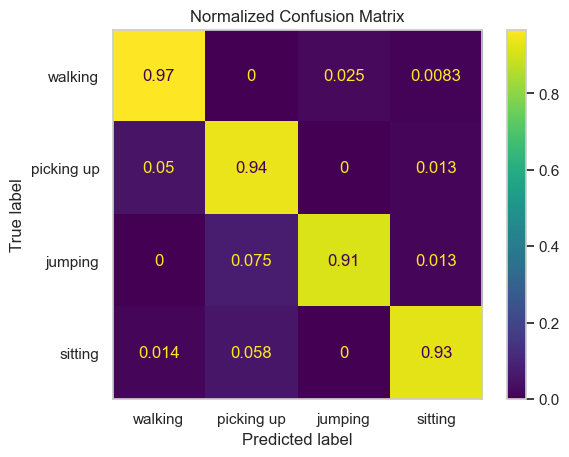

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Normalize the confusion matrix by row (true label)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plotting the confusion matrix
class_names = ['walking', 'picking up', 'jumping', 'sitting']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm_normalized, display_labels=class_names)

# Display the plot without grid lines
disp.plot()
plt.title("Normalized Confusion Matrix")
plt.gca().grid(False)  # Remove grid lines
plt.show()


In [141]:
def class_preds(DATA_DIR, model):
    files = glob(os.path.join(DATA_DIR, "[!README]*"))
    predictions = []
    for f in files:
        try:
            with open(f, 'rb') as file:
                
                data = pickle.load(file)
                test_points = []
                sample_test_points = []
                for arr in data:
                    bg_rm_arr = background_subtraction(background_data, arr)
                    sample_test_points.append(bg_rm_arr)
                
                data = np.concatenate(sample_test_points, axis=0)
                np.random.seed(42)
                sampled_indices = np.random.choice(data.shape[0], size=300, replace=True)
                sampled_data = data[sampled_indices].astype(np.float16)
                test_points.append(sampled_data)
                # train_labels.append(i)
                # data = np.array(data).reshape(1,300,5)
                test_points = np.array(test_points)
                preds = model.predict(test_points)  # Get predictions for the current batch
                print("pred is", preds)
                print(batch.shape)
                preds = np.argmax(preds, axis=-1)  # Get the class with the highest probability
                print("argmax is", preds)
                predictions.extend(preds)  # Extend the predictions list with the results
        except Exception as e:
            print(f"Error processing file {f}: {e}")

    predictions = np.array(predictions)
    return predictions
